Dependencies and Imports

In [127]:
import pandas as pd
import numpy as np
import geopandas as gpd
import json
import networkx as nx
import matplotlib.pyplot as plt
from libpysal import weights, examples

In [128]:
ddb = gpd.read_file('./data/ddb_roundabout.geojson')

In [129]:
roads = gpd.read_file('./data/roundabout.geojson')

In [130]:
def check_graph(nxgraph):
    # Check if the graph has any nodes.
    print("Graph nodes:")
    if nxgraph.number_of_nodes() > 0:
        print("The graph has nodes.")
        #count number of nodes
        print("Number of nodes:", nxgraph.number_of_nodes())
    else:
        print("The graph does not have any nodes.")
    # Check if the graph has any edges.
    print("\nGraph edges:")
    if nxgraph.number_of_edges() > 0:
        print("The graph has edges.")
        #count number of edges
        print("Number of edges:", nxgraph.number_of_edges())
    else:
        print("The graph does not have any edges.")
    # Check if the graph is connected.
    print("\nGraph connection:")
    if nx.is_connected(nxgraph):
        print("The graph is connected.")
    else:
        print("The graph is disconnected.")
        

Use the roundabout to make one part of the node, the ddb to make another part of the node, and then use the relationship between incident and road to make the edge.

Roads have their own attributes, such as length, width, and number of lanes. Incidents also have certain attributes, such as speed and acceleration.

The relationship between incident and roundabout is distance, nearby arc, and how many kilometers on the road it is.

Examples:

https://networkx.org/nx-guides/content/exploratory_notebooks/facebook_notebook.html

https://networkx.org/nx-guides/content/generators/geometric.html

Graph for coordinates of DDB


https://networkx.org/documentation/stable/auto_examples/geospatial/plot_points.html
https://networkx.org/documentation/stable/auto_examples/geospatial/plot_delaunay.html
https://networkx.org/documentation/stable/auto_examples/geospatial/plot_delaunay.html

In [131]:
ddb_coordinates = np.column_stack((ddb.geometry.x, ddb.geometry.y))

In [132]:
dist = weights.DistanceBand.from_array(ddb_coordinates, threshold=4000)

c:\Python311\Lib\site-packages\libpysal\weights\weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  warnings.warn(message)


In [133]:
incidents = dist.to_networkx()

In [134]:
incident_loc = dict(zip(incidents.nodes, ddb_coordinates))

In [135]:
incident_loc

{0: array([16595825.83481508, -4208110.69446205]),
 1: array([16597539.70969533, -4206559.21011938]),
 2: array([16597539.70969533, -4206559.21011938]),
 3: array([16597536.37011061, -4206536.83716083]),
 4: array([16597536.37011061, -4206536.83716083]),
 5: array([16597543.16059954, -4207490.32012003]),
 6: array([16597551.62088084, -4207244.60858877]),
 7: array([16597527.79850981, -4206547.20511159]),
 8: array([16597527.79850981, -4206547.20511159]),
 9: array([16597539.70969533, -4206546.65942973]),
 10: array([16597539.70969533, -4206546.65942973]),
 11: array([16596671.19502816, -4206458.94142125]),
 12: array([16593495.36127532, -4209304.19799278]),
 13: array([16597512.54773958, -4206532.60813108]),
 14: array([16597543.16059954, -4206512.96362703]),
 15: array([16596700.58337373, -4206458.80500188]),
 16: array([16595778.30139251, -4207938.37233618]),
 17: array([16597543.16059954, -4206591.95111611]),
 18: array([16597543.16059954, -4206591.95111611]),
 19: array([16597554.9

In [136]:
incidents.remove_edges_from(list(incidents.edges()))

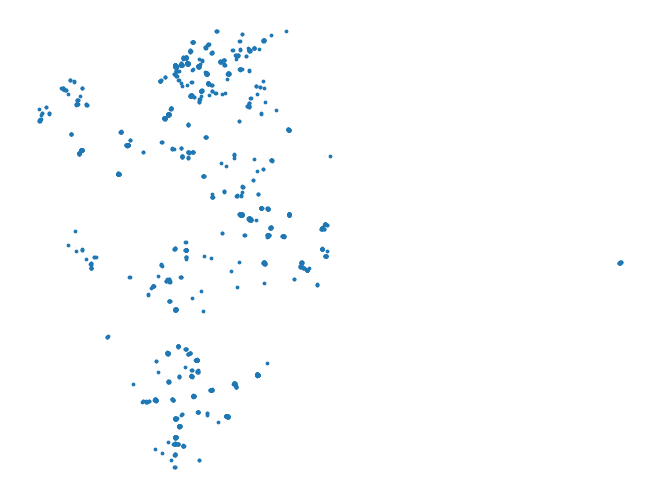

In [137]:
nx.draw(incidents, incident_loc, node_size=3)
plt.show()

In [138]:
check_graph(incidents)

Graph nodes:
The graph has nodes.
Number of nodes: 2167

Graph edges:
The graph does not have any edges.

Graph connection:
The graph is disconnected.


Graph of roundabouts

https://networkx.org/documentation/stable/auto_examples/geospatial/plot_polygons.html

In [139]:
centres = np.column_stack((roads.centroid.x, roads.centroid.y))

C:\Users\User\AppData\Local\Temp\ipykernel_26336\4075229338.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centres = np.column_stack((roads.centroid.x, roads.centroid.y))


In [140]:
queen = weights.Queen.from_dataframe(roads)

C:\Users\User\AppData\Local\Temp\ipykernel_26336\3323957876.py:1: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  queen = weights.Queen.from_dataframe(roads)
c:\Python311\Lib\site-packages\libpysal\weights\weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 463 disconnected components.
 There are 355 islands with ids: 0, 1, 2, 3, 9, 14, 16, 21, 22, 24, 25, 30, 31, 32, 33, 34, 49, 50, 51, 54, 55, 56, 57, 58, 61, 62, 65, 67, 68, 69, 71, 72, 76, 80, 81, 82, 83, 84, 86, 87, 88, 89, 90, 94, 95, 100, 101, 102, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 116, 117, 119, 120, 126, 127, 130, 131, 132, 136, 137, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 176, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190,

In [141]:
graph = queen.to_networkx()

In [142]:
positions = dict(zip(graph.nodes, centres))

In [143]:
positions

{0: array([149.02756081, -35.20241201]),
 1: array([149.03342439, -35.20591569]),
 2: array([149.02893925, -35.19940623]),
 3: array([149.02720187, -35.2054736 ]),
 4: array([149.16482232, -35.22475989]),
 5: array([149.15177766, -35.30234821]),
 6: array([149.16171019, -35.30312312]),
 7: array([149.08669825, -35.33483022]),
 8: array([149.1657344 , -35.28722291]),
 9: array([149.15349344, -35.2968599 ]),
 10: array([149.15172949, -35.28288854]),
 11: array([149.13959648, -35.29026667]),
 12: array([149.13456403, -35.28742842]),
 13: array([149.14719078, -35.2825795 ]),
 14: array([149.12104387, -35.24932678]),
 15: array([149.07854705, -35.42388173]),
 16: array([149.08751788, -35.35071508]),
 17: array([149.09155101, -35.3570658 ]),
 18: array([149.14498604, -35.40538607]),
 19: array([149.09115449, -35.43777731]),
 20: array([149.14980212, -35.32305582]),
 21: array([149.12258343, -35.28048062]),
 22: array([149.12391562, -35.25185961]),
 23: array([149.15416287, -35.2473118 ]),
 2

In [144]:
graph.remove_edges_from(list(graph.edges()))

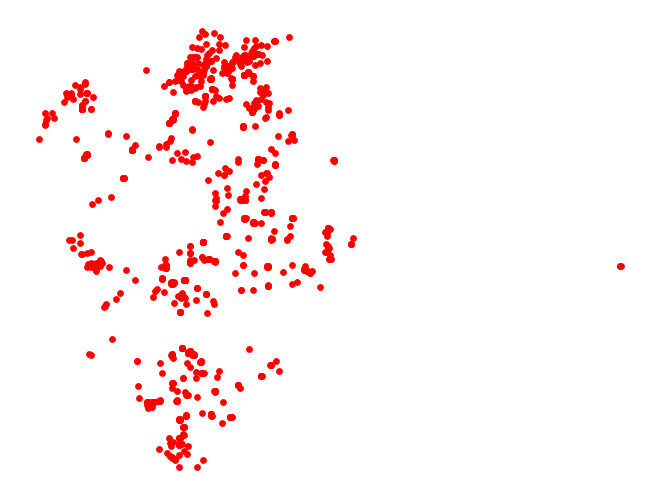

In [145]:
nx.draw(graph, positions, node_size=15, node_color="r")
plt.show()

In [146]:
check_graph(graph)

Graph nodes:
The graph has nodes.
Number of nodes: 904

Graph edges:
The graph does not have any edges.

Graph connection:
The graph is disconnected.


Merge two graphs and connect them with edges

idea is to join them into a single graph first and then start to find the edges method